[![Open in Kaggle](https://img.shields.io/badge/Open%20in-Kaggle-blue?logo=kaggle&logoColor=white)](https://www.kaggle.com/code/suriyaem/gan-s)


```
So Here we can take advantage of kaggle's 2xGPU-t4. so only DCGAN is implemented in DDP
```

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2

import matplotlib.pyplot as plt
from PIL import Image

import os
import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("current device ->" ,device)

current device -> cuda


# *Data Preprocessing*

In [8]:
# directory contains all the image files
images_dir = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"
dataset_size = len(os.listdir(images_dir))

print("Total number of images:", dataset_size)

Total number of images: 202599


In [ ]:
class GanDataset(Dataset):
    """
    Custom Dataset:
        Handles image open/read operations from dir.
        Converts to tensor format.
    """
        
    def __init__(self, images_dir: str):
    
        self.images_dir = images_dir
        self.image_paths = sorted(os.listdir(self.images_dir)) # list of image file names

        # pipeline that takes image do multiple transformation
        self.transform =  v2.Compose([
                v2.ToImage(), # converts to tensor with dtype uint8 shape (C, H, W)
                # actuall image size 200x178 if we use conv then 200x200 or 64x64 as in DCGAN, if linear 100x100 else reduce tiny
                v2.Resize((64, 64), antialias = True),  
                v2.ToDtype(torch.float32, scale = True), 
            ])
        
    def __len__(self)-> int:
        """
        Returns dataset set size
        """
        return len(self.image_paths)

    def __getitem__(self, idx: int)-> torch.Tensor:
        """
        Takes data sample id and returns sample from the dataset
        """
        # cancate dir with file name 
        img_path = os.path.join(self.images_dir, self.image_paths[idx]) 
        # read image
        image = Image.open(img_path).convert("RGB")
        # do preprocessing on that image -> gives as tensor 
        image = self.transform(image)             # (C, H, W)
        return image

In [ ]:
batch_size = 64

# Dataset
gan_dataset = GanDataset(images_dir)
# Dataloader
dataloader = DataLoader(gan_dataset, 
                        batch_size = batch_size, 
                        num_workers = 3, 
                        pin_memory = True, 
                        shuffle = True, 
                        drop_last = True)

# *1. GAN - Generative Adversarial Network*

## *A. GAN Implementation*

In [ ]:
class Generator(nn.Module):
  """
  Generator network:
    Takes random Noise and Trying to models the distripution of real data.
    In simple term, generator trying generate fake image that so good even discriminator can't tell the different

  """

  def __init__(self, noise_shape: int, out_features: int):
    super().__init__()

    """
    Args:

      noise_shape (int): Shape of noise
      out_features (int): Output size . good if we use same size as image

    """

    # layer 1
    self.l1 = nn.Sequential(
      nn.Linear(noise_shape, 256),
      nn.BatchNorm1d(256),
      nn.LeakyReLU(negative_slope= 0.2)
    )

    # layer 2
    self.l2 = nn.Sequential(
      nn.Linear(256, 128),
      nn.BatchNorm1d(128),
      nn.LeakyReLU(negative_slope= 0.2) ,
    )

    # layer 3
    self.l3 = nn.Sequential(
      nn.Linear(128, 64),
      nn.BatchNorm1d(64),
      nn.LeakyReLU(negative_slope= 0.2)
    )

    # finall layer
    self.final = nn.Sequential(
        nn.Linear(64, out_features),
    )

    # total number of parameters in the model
    print(f"{self.__class__.__name__} Network parameters: {self._get_parameters_count()}")

  def _get_parameters_count(self)-> int:
    """
    Returns Parameters Count
    """
    t = 0
    for p in self.parameters():
      t += p.nelement()
    return t


  def forward(self, x: torch.Tensor)-> torch.Tensor:
    out = self.final(self.l3(self.l2(self.l1(x))))
    # reshape to same shape as image
    out = out.view(out.size(0), 3, 100, 100)
    return out
      

class Discriminator(nn.Module):
  """
  Discriminator Network:
    Tells which image is Fake and which image is Real.
    Finding differnece between fake image generated by Generator Network and Real Image

  """
  def __init__(self, in_features: int, out_features: int = 1):
    super().__init__()

    """

    Args:
      in_features (int): Dimentionality of Generator's Ouput
      out_features (int): Dimentionality of Ouput. Default to 1 cause of sigmoid

    """

    self.l1 = nn.Sequential(
        nn.Flatten(start_dim=1),
        nn.Linear(in_features, 256),
        # nn.BatchNorm1d(256),
        nn.LeakyReLU(negative_slope= 0.2),
        nn.Dropout1d(p= 0.1)
    )

    self.l2 = nn.Sequential(
        nn.Linear(256, 128),
        # nn.BatchNorm1d(128),
        nn.LeakyReLU(negative_slope= 0.2),
        nn.Dropout1d(p= 0.1)

    )

    self.l3 = nn.Sequential(
        nn.Linear(128, 64),
        # nn.BatchNorm1d(64),
        nn.LeakyReLU(negative_slope= 0.2),
        # nn.Dropout1d(p= 0.5)

    )

    self.final = nn.Sequential(
        nn.Linear(64, 1),
        # nn.Sigmoid()
    )

     # total number of parameters in the model
    print(f"{self.__class__.__name__} Network parameters: {self._get_parameters_count() }")

  def _get_parameters_count(self)-> int:
    """
    Returns Parameters Count
    """
    t = 0
    for p in self.parameters():
      t += p.nelement()
    return t

  def forward(self, x: torch.Tensor)-> torch.Tensor:
    """
    Args:
      x (torch.Tensor): Output from generator network

    Return:
      out (torch.Tensor): For Each Image gives score (0 to 1) How much is it Fake or Real. shape (B, 1)

    """
    out = self.final(self.l3(self.l2(self.l1(x))))
    return out

## *B. GAN Training*

In [ ]:
C, H, W = image_shape = 3, 100, 100        # (C, H, W)
out_features = C * H * W                   # GAN Output dimentionality

# Hyperparameters
noise_dim = 100                            # z-noise dimentionality
epochs = 1                      # Number of steps we what to train our model
lr = 0.002                      # learning step size
weight_decay: float = 1e-1      # weight decay
k = 1                           # How many steps do we want to train discriminator

In [ ]:
# Generator Network
G = Generator(noise_dim, out_features).to(device)
torch.compile(G)
# Discriminator Network
D = Discriminator(out_features).to(device)
torch.compile(D)

print("Models are compiled")

In [ ]:
# Binary Cross Entropy Loss
criterion = nn.BCEWithLogitsLoss()

# Generator optimizer
opt_G = optim.AdamW(G.parameters(), lr = lr)
# Discriminator optimier
opt_D = optim.AdamW(D.parameters(), lr = lr, weight_decay = weight_decay)

In [ ]:
d_lossi = []
g_lossi = []

start = time.time()
# Optimization Loop
for epoch in range(epochs):
    if (epoch % 1 == 0 or epoch == epochs - 1):
        print("Epoch", epoch + 1)

    every_print_start_time = time.time()               
    for batch, real_imgs in enumerate(dataloader, 0):
        real_imgs = real_imgs.to(device, non_blocking = True)

        batch_start_time = time.time()       # how long takes to process on batch
        for _ in range(k):

            # ---------------------
            # A.Train Discriminator
            # --------------------
            G.requires_grad_(False)
            D.requires_grad_(True)
            opt_D.zero_grad()

            real_labels = torch.ones(batch_size, 1, device = device) #- 0.01

            noise = torch.randn(batch_size, noise_dim, device = device)     # z-noise
            fake_labels = torch.zeros(batch_size, 1, device = device)

            with torch.autocast(device_type = device, dtype = torch.bfloat16):
                # Real Batch
                pred_real = D(real_imgs)
                loss_real = criterion(pred_real, real_labels)
    
                # Fake Batch
                fake_imgs = G(noise).detach()     # make sure we don't train G when traning D
                pred_fake = D(fake_imgs)
                loss_fake = criterion(pred_fake, fake_labels)

            # back-prop and update D parameters
            loss_D = (loss_real + loss_fake) * 0.5
            loss_D.backward()
            opt_D.step()

            d_lossi.append(loss_D.item())

        # -----------------
        # B.Train Generator
        # ---------------- 
        G.requires_grad_(True)
        D.requires_grad_(False)
        opt_G.zero_grad()

        noise = torch.randn((batch_size, noise_dim), device = device)
        target_labels = torch.ones(batch_size, 1, device = device) #- 0.1

        with torch.autocast(device_type = device, dtype = torch.bfloat16):
            generated = G(noise)
            # fool the D to think it's reciving real images
            pred = D(generated)
            loss_G = criterion(pred, target_labels)
        
        # back-prop and update G parameters
        loss_G.backward()
        opt_G.step()

        batch_end_time = time.time()
        g_lossi.append(loss_G.item())

        t = batch_end_time - batch_start_time
        
        if (epoch % 10 == 0 or epoch == epochs - 1) and ( batch % 200 == 0 or batch == dataloader.__len__()-1):
            every_print_end_time = time.time()
            e_t = every_print_end_time - every_print_start_time
            print(f"{dataloader.__len__()}/{batch}: D: loss_real {loss_real}, loss_fake {loss_fake} G: loss {loss_G} SB_t: {t:2f} s, EP_t : {e_t:2f} s")
            every_print_start_time = time.time()
            
end = time.time()
print("training time %.2f" % ((end - start)/60),"M")

```
SB_t -> time taken for single batch (1 batch to process)
EP_t -> time taken for Every print (200 batch to processs)

with complie, on t4, num_workers = 3, no amp (even with amp cause we don't do big mm thats where amp shines), no ddp .(slower than p100)
SB_t: 0.011698 s, EP_t : ~ 16.843494 s

with compile, on p100, num_workers = 3,
SB_t: 0.010224 s, EP_t : ~ 12.811517 s

with compile, on p100, num_workers = 2
0.010657 s, EP_t : 22.856203 s

with compile, on p100, num_workers = 1 (here we have dataload latency), no amp
SB_t: 0.008242 s, EP_t : 39.551564 s  

without compile, on cpu, num_workers = 2, no amp
SB_t: ~ 0.154181 s , EP_t : ~ 30.116826 s

with compile, on cpu (just a waste)
SB_t: ~ 0.161146 s, EP_t : ~ 33.337325 s

```

## *C. Sampling from GAN*

In [ ]:
# sampling from GAN
G.eval()
noise = torch.randn((20, noise_dim), device= device)
generated_img = G(noise)                          # (B, C, H, W)
generated_img = generated_img.permute(0, 2, 3, 1) # (B, H, W, C)

In [ ]:
# plotting gan's generated image
fig, axs = plt.subplots(4, 5)

idx = 0
for i in range(4):
    for j in range(5):
        axs[i, j].axis("off")
        axs[i, j].imshow(generated_img.cpu()[idx].detach())
        idx += 1

# *2. DCGAN - Deep Convolutional Adversarial Network*

#### *Here DCGAN implemented as Script cause we wanna train DCGAN in two GPU-t4 that's available. Distributed Data Parallel take care of that*.

```
Overview of DDP in unformal way 😶:

    1. Each GPU (process) has it own copy of model (DCGAN).
    2. During training each copy of model recive different Batch of Samples. 
      (eg: dataset_size = 64 model-1 recives (0-31 batch), model-2 recives (32-64)
    3. During forward each model, it's like training on it's own sample batch in parallel
    4. When Backward pass gradients not directly used to update parameters. Instead we take average or whatever scheme over across process and then            that averaged gradients used to update model.
    5. So at the end of the backward pass all parameters are same across process

```



## *A. Implementing DCGAN*

In [84]:
# we use this as standlone file 
# when you run this cell it will create train_ddp.py in working directory
# after that you can download python script or train here as i did in below 

%%writefile train_ddp.py

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.multiprocessing as mp

from PIL import Image

import os
import time

# current device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# directory contains all the image files
images_dir = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"

def setup(rank, world_size):
    os.environ["MASTER_ADDR"] = "127.0.0.1"
    os.environ["MASTER_PORT"] = "12355"
    dist.init_process_group("nccl", rank=rank, world_size=world_size)

# after training we have to destroy the ddp
def cleanup():
    dist.destroy_process_group()

class GanDataset(Dataset):
    """
    Custom Dataset:
        Handles image open/read operations from dir.
        Converts to tensor format.
    """
        
    def __init__(self, images_dir: str):
    
        self.images_dir = images_dir
        self.image_paths = sorted(os.listdir(self.images_dir)) # list of image file names

        # pipeline that takes image do multiple transformation
        self.transform =  v2.Compose([
                v2.ToImage(), # converts to tensor with dtype uint8 shape (C, H, W)
                # actuall image size 200x178 if we use conv then 200x200 or 64x64 as in DCGAN, if linear 100x100 else reduce tiny
                v2.Resize((64, 64), antialias = True),  
                v2.ToDtype(torch.float32, scale = True), 
            ])
        
    def __len__(self)-> int:
        """
        Returns dataset set size
        """
        return len(self.image_paths)

    def __getitem__(self, idx: int)-> torch.Tensor:
        """
        Takes data sample id and returns sample from the dataset
        """
        # cancate dir with file name 
        img_path = os.path.join(self.images_dir, self.image_paths[idx]) 
        # read image
        image = Image.open(img_path).convert("RGB")
        # do preprocessing on that image -> gives as tensor 
        image = self.transform(image)             # (C, H, W)
        return image


class Generator(nn.Module):
    """
    Generator Network: Uses Conv nets instead of FCN
    """

    def __init__(self, noise_dim)-> None:
        super().__init__()

        # layer 1. just a linear projection
        self.l_proj = nn.Linear(noise_dim, 4 * 4 * 1024, bias = False) # reshape to (B, 1024, 4, 4)

        # layer 2
        self.tconv1 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 5, 2, padding= 2, output_padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        ) # (B, 512, 8, 8)

        # layer 3
        self.tconv2 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 5, 2, padding= 2, output_padding= 1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        ) # (B, 256, 16, 16)

        # layer 4
        self.tconv3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 5, 2, padding = 2, output_padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        ) # (B, 128, 32, 32)


        # layer 5
        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, 3, 5, 2, padding= 2, output_padding= 1),
            nn.Tanh()
        ) # (B, 3, 64, 64)

        # weight initialization
        self.apply(self._init_weights)

        # report parameters count
        print(f"{self.__class__.__name__} Network parameters : {self._get_parameters_count()/ 1e+6 :2f}M")

    def _get_parameters_count(self)-> int:
        """
        Returns Parameters counts in Model
        """
        t = 0
        for p in self.parameters():
            t += p.nelement()
        return t


    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.normal_(m.weight, mean = 0.0, std = 0.02)
            if m.bias is not None:
                nn.init.normal_(m.bias, mean = 0.0, std = 0.02)

        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, mean = 0.0, std = 0.02)
            if m.bias is not None:
                nn.init.normal_(m.bias, mean = 0.0, std = 0.02)

    def forward(self, x: torch.Tensor)-> torch.Tensor:
        out = self.final(self.tconv3((self.tconv2(self.tconv1(self.l_proj(x).reshape(-1, 4, 4, 1024).permute(0, 3, 1, 2))))))
        return out

class Discriminator(nn.Module):

    """
    Discriminator Network: Uses Conv nets instead of FCN
    """

    def __init__(self, out_features = 1):
        super().__init__()

        # layer 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 128, 5, 2, padding = 2),
            nn.LeakyReLU(negative_slope= 0.2, inplace=False)
        ) # (B, 128, 32, 32)

        # layer 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 256, 5, 2, padding = 2),
            nn.InstanceNorm2d(256, affine=True),                  # i don't know why when using BatchNorm in ddp, got gradients in-place operation error
            nn.LeakyReLU(negative_slope= 0.2, inplace=False)
        ) # (B, 256, 16, 16)

        # layer 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 512, 5, 2, padding = 2),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(negative_slope= 0.2, inplace=False)
        ) # (B, 512, 8, 8)

        # final layer
        self.final = nn.Sequential(
            # nn.Conv2d(512, 1024, 5, 2, padding = 2), # -> this conv takes ~13 M params in 17M 🤣
            nn.Flatten(start_dim= 1),
            nn.Linear(512 * 8 * 8, 1, bias = False),
        ) # (B, 1024, 4, 4) -> (B, 512 * 8 * 8) -> (B, 1)

        # weight initialization
        self.apply(self._init_weights)

        # report parameters count
        print(f"{self.__class__.__name__} Network parameters : {self._get_parameters_count()/1e+6 :2f}M")

    def _get_parameters_count(self) -> int:
        """
        Returns Parameters counts in Model
        """
        t = 0
        for p in self.parameters():
            t += p.nelement()
        return t

    def _init_weights(self, m)-> None:
        if isinstance(m, nn.Conv2d):
            nn.init.normal_(m.weight, mean = 0.0, std = 0.02)
            if m.bias is not None:
                nn.init.normal_(m.bias, mean = 0.0, std = 0.02)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, mean = 0.0, std = 0.02)
            if m.bias is not None:
                nn.init.normal_(m.bias, mean = 0.0, std = 0.02)


    def forward(self, x: torch.Tensor)-> torch.Tensor:
        """
        Args:
            x (torch.Tensor): Output of Generator Network

        Returns:
            out (torch.Tensor): Scaler Tensor does the image is Real/Fake value B/W 0-1

        """
        out = self.final(self.conv3(self.conv2(self.conv1(x))))
        return out

# batch size 
batch_size = 64
noise_dim = 100

# Hyperparameters
epochs = 2                     # Number of steps we what to train our model
lr = 0.002                     # learning step size
weight_decay: float = 1e-1     # weight decay
k = 1                          # How many steps do we want to train discriminator


def gan_train(rank: int, world_size: int):
    
    print(f"Rank [{rank}] Initializing DDP")
    setup(rank, world_size) 

    # ----------------
    # DataLoader setup
    # ----------------
          
    # Dataset
    gan_dataset = GanDataset(images_dir)
    # distributed sampler take cares spliting of dataset batch correctly without overlap
    dist_sampler = DistributedSampler(gan_dataset,
                                      num_replicas=world_size,
                                      rank=rank,
                                      shuffle = True)
    # Dataloader
    dataloader = DataLoader(gan_dataset, 
                        batch_size = batch_size, 
                        num_workers = 3, 
                        pin_memory = True, 
                        sampler = dist_sampler,
                        drop_last = True)
    
    if rank == 0:
        print(f"dataset size = {len(gan_dataset)}")
        print("Batches =", len(dataloader))
        print(f"world_size (GPU's) = {world_size}")


    #---------------------
    # Initializing models
    # ---------------------
    
    torch.manual_seed(42)

    G = Generator(noise_dim).to(rank)
    torch.compile(G)
    ddp_G = DDP(G, device_ids = [rank])
    
    D = Discriminator().to(rank)
    torch.compile(D)
    ddp_D = DDP(D, device_ids = [rank])

    # Binary Cross Entropy Loss
    criterion = nn.BCEWithLogitsLoss()
    
    # Generator optimizer
    opt_G = optim.AdamW(ddp_G.parameters(), lr = lr, betas=(0.5, 0.999))
    # Discriminator optimier
    opt_D = optim.AdamW(ddp_D.parameters(), lr = lr, weight_decay = weight_decay, betas=(0.5, 0.999))

    #------------------
    # Optimization Loop
    #------------------
    
    start = time.time()
    
    torch.autograd.set_detect_anomaly(True)
    for epoch in range(epochs):
        dist_sampler.set_epoch(epoch)             # for shuffing dataset
        
        if rank == 0 and (epoch % 1 == 0 or epoch == epochs - 1):
            print("Epoch", epoch + 1)
            
        every_print_start_time = time.time()       
        
        for batch, real_images in enumerate(dataloader, 0):
            real_imgs = real_images.to(rank, non_blocking = True)
            
            batch_start_time = time.time()       # how long takes to process on per-batch
            for _ in range(k):
    
                # ---------------------
                # A.Train Discriminator
                # --------------------
                ddp_G.requires_grad_(False)
                ddp_D.requires_grad_(True)
                opt_D.zero_grad()
                assert real_imgs.shape == (64, 3, 64, 64), f"real image shape {real_imgs.shape}" 
                
                real_labels = torch.ones(batch_size, 1,).to(rank) #- 0.01
                noise = torch.randn(batch_size, noise_dim).to(rank)     # z-noise
                fake_labels = torch.zeros(batch_size, 1).to(rank)
    
                with torch.autocast(device_type = device, dtype = torch.bfloat16):
                    # Real Batch
                    pred_real = ddp_D(real_imgs)
                    loss_real = criterion(pred_real, real_labels)
        
                    # Fake Batch
                    fake_imgs = ddp_G(noise).detach()     # make sure we don't train G when traning D
                    pred_fake = ddp_D(fake_imgs)
                    loss_fake = criterion(pred_fake, fake_labels)
                    
                    loss_D = (loss_real + loss_fake) * 0.5
                    
                # back-prop and update D parameters    
                loss_D.backward()
                opt_D.step()
    
                # d_lossi.append(loss_D.item())
    
            # -----------------
            # B.Train Generator
            # ---------------- 
            ddp_G.requires_grad_(True)
            ddp_D.requires_grad_(False)
            opt_G.zero_grad()
    
            g_noise = torch.randn((batch_size, noise_dim)).to(rank)
            target_labels = torch.ones(batch_size, 1).to(rank) #- 0.1
    
            with torch.autocast(device_type = device, dtype = torch.bfloat16):
                generated = ddp_G(g_noise)
                # fool the D to think it's reciving real images
                pred = ddp_D(generated)
                loss_G = criterion(pred, target_labels)
            
            # back-prop and update G parameters
            loss_G.backward()
            opt_G.step()
    
            batch_end_time = time.time()
            # g_lossi.append(loss_G.item())
            t = batch_end_time - batch_start_time

            # saving checkpoint at every 200 batch
            if rank == 0 and (batch % 200 == 0 or batch == dataloader.__len__() - 1):
                ckp = ddp_G.module.state_dict()
                PATH = "checkpoint.pt"
                torch.save(ckp, PATH)
                print(f"batch {batch} | Training checkpoint is saved at {PATH}")
            
            if (epoch % 1 == 0 or epoch == epochs - 1) and ( batch % 200 == 0 or batch == dataloader.__len__()-1):
                every_print_end_time = time.time()
                e_t = every_print_end_time - every_print_start_time
                print(f"Rank [{rank}] {dataloader.__len__()}/{batch }: D: loss_real {loss_real}, loss_fake {loss_fake} G: loss {loss_G} SB_t: {t:2f} s, EP_t : {e_t:2f} s")
                every_print_start_time = time.time()
                
        # saving checkpoint at every epoch
        if rank == 0 and epoch % 1 == 0:
            ckp = ddp_G.module.state_dict()
            PATH = "echeckpoint.pt"
            torch.save(ckp, PATH)
            print(f"Epoch {epoch} | Training checkpoint is saved at {PATH}")

    end = time.time()
    print("training time %.2f" % ((end - start)/60),"M")

    # after training destroy ddp
    cleanup()

def run_ddp_gan():
    world_size = torch.cuda.device_count()
    mp.spawn(gan_train, args=(world_size,), nprocs=world_size, join=True)

if __name__ == "__main__":
    run_ddp_gan()

Overwriting train_ddp.py


## *B. Training DCGAN*

In [85]:
!python train_ddp.py

Rank [0] Initializing DDP
Rank [1] Initializing DDP
dataset size = 202599
Batches = 1582
world_size (GPU's) = 2
Generator Network parameters : 18.853891M
Generator Network parameters : 18.853891M
Discriminator Network parameters : 4.140800M
Discriminator Network parameters : 4.140800M
Epoch 1
Rank [1] 1582/0: D: loss_real 0.8467645645141602, loss_fake 2.0580923557281494 G: loss 79.0234375 SB_t: 1.305493 s, EP_t : 13.452738 s
batch 0 | Training checkpoint is saved at checkpoint.pt
Rank [0] 1582/0: D: loss_real 0.6678957939147949, loss_fake 2.0580923557281494 G: loss 79.0234375 SB_t: 1.762838 s, EP_t : 13.696295 s
Rank [1] 1582/200: D: loss_real 2.265187978744507, loss_fake 0.5732411742210388 G: loss 1.3879145383834839 SB_t: 0.836731 s, EP_t : 166.908952 s
batch 200 | Training checkpoint is saved at checkpoint.pt
Rank [0] 1582/200: D: loss_real 2.2561357021331787, loss_fake 0.5732411742210388 G: loss 1.3879145383834839 SB_t: 0.840407 s, EP_t : 166.917388 s
Rank [1] 1582/400: D: loss_real

```
with t4, ddp, with batch_size = 64
0.830421 s, EP_t : 165.866040 s            (actually 64 * 2 batch_size training)

with p100, no ddp, with batch_size = 128
SB_t: 1.046843 s, EP_t : 296.304646 s       ( 75.17 * 4 = 300.68 s , same as doing 32 batch 4 times)

with p100 , no ddp, with batch_size = 32
SB_t: 0.183245 s, EP_t : 75.170432 s
```

## *C. Sampling from DCGAN*

In [75]:
class Generator(nn.Module):
    """
    Generator Network: Uses Conv nets instead of FCN
    """

    def __init__(self, noise_dim)-> None:
        super().__init__()

        # layer 1. just a linear projection
        self.l_proj = nn.Linear(noise_dim, 4 * 4 * 1024, bias = False) # reshape to (B, 1024, 4, 4)

        # layer 2
        self.tconv1 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 5, 2, padding= 2, output_padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        ) # (B, 512, 8, 8)

        # layer 3
        self.tconv2 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 5, 2, padding= 2, output_padding= 1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        ) # (B, 256, 16, 16)

        # layer 4
        self.tconv3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 5, 2, padding = 2, output_padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        ) # (B, 128, 32, 32)


        # layer 5
        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, 3, 5, 2, padding= 2, output_padding= 1),
            nn.Tanh()
        ) # (B, 3, 64, 64)

        # weight initialization
        self.apply(self._init_weights)

        # report parameters count
        print(f"{self.__class__.__name__} Network parameters : {self._get_parameters_count()/ 1e+6 :2f}M")

    def _get_parameters_count(self)-> int:
        """
        Returns Parameters counts in Model
        """
        t = 0
        for p in self.parameters():
            t += p.nelement()
        return t


    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.normal_(m.weight, mean = 0.0, std = 0.02)
            if m.bias is not None:
                nn.init.normal_(m.bias, mean = 0.0, std = 0.02)

        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, mean = 0.0, std = 0.02)
            if m.bias is not None:
                nn.init.normal_(m.bias, mean = 0.0, std = 0.02)

    def forward(self, x: torch.Tensor)-> torch.Tensor:
        out = self.final(self.tconv3((self.tconv2(self.tconv1(self.l_proj(x).reshape(-1, 4, 4, 1024).permute(0, 3, 1, 2))))))
        return out

noise_dim = 100
G = Generator(noise_dim).to(device)

Generator Network parameters : 18.853891M


In [90]:
# loading trained checkpoint
G.load_state_dict(torch.load("echeckpoint.pt", weights_only = True))

<All keys matched successfully>

In [91]:
# # sampling from DCGAN
G.eval()
noise = torch.randn((20, noise_dim), device= device)
generated_img = G(noise)                          # (B, C, H, W)
generated_img = generated_img.permute(0, 2, 3, 1) # (B, H, W, C)

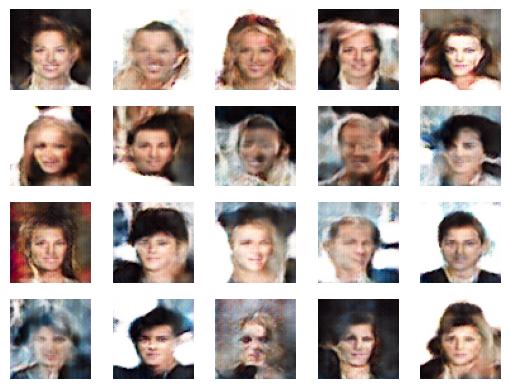

In [92]:
# plotting DCGAN's generated image
fig, axs = plt.subplots(4, 5)

idx = 0
for i in range(4):
    for j in range(5):
        axs[i, j].axis("off")
        axs[i, j].imshow(generated_img.cpu()[idx].detach())
        idx += 1